In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [54]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/MC_Autumn18/v12/v6/'
bkg_path = path+"/bkg/wH/normalized/"
# fpath_bkg['QCD'] = bkg_path+"QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['DYJetsToLL'] = bkg_path+"DYJetsToLL_M-50_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root"
# fpath_bkg['TTJets_DiLept'] = bkg_path+"TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['TTJets_SingleLeptFromTbar'] = bkg_path+"TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['TTJets_SingleLeptFromT'] = bkg_path+"TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['ZJetsToNuNu'] = bkg_path+"ZJetsToNuNu_Zpt-100toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['WJetsToLNu'] = bkg_path+"WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root"
# fpath_bkg['WJetsToLNu'] = bkg_path+"WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
fpath_bkg['WJetsToLNu'] = bkg_path+"WJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root"




start_t = time.time()
data_year = 2018
if data_year == 2016:lumi = 35.92*1000 #in pb-1
elif data_year == 2017:lumi = 41.53 * 1000
else: lumi = 59.74 * 1000
    
data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/Data'+str(data_year)+'/v12/v6/wH/normalized/'
fpath_bkg['SingleMuon'] = data_path + 'SingleMuon.root'
if data_year == 2018:
    fpath_bkg['SingleElectron'] = data_path + 'EGamma.root'
else:
    fpath_bkg['SingleElectron'] = data_path + 'SingleElectron.root'




NEvents = {}


for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
#     if k[:7] == 'ntuples':
#         tree_bkg[k] = root_dir['ntuples']['llp']
#         NEvents[k] = root_dir['ntuples']['NEvents'][1]
#     else:
    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["weight"].array()
    print("NEvents",NEvents[k])
    print ('weights',np.unique(a)*lumi)
    print(np.sum(a))
    print(len(a))
#     print(len(a)/ NEvents[k])
#     print(a.shape)
print(time.time()-start_t)

WJetsToLNu /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/MC_Autumn18/v12/v6//bkg/wH/normalized/WJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root
NEvents 213009000.0
weights [-51.52663   -51.011368  -10.477483  -10.372707  -10.268981  -10.166291
  -7.009751   -6.9396534  -6.8702564  -6.801554    0.          6.801554
   6.8702564   6.9396534   7.009751   10.064628   10.166291   10.268981
  10.372707   10.477483   50.501247   51.011368   51.52663  ]
37.227646
540252
SingleMuon /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/Data2018/v12/v6/wH/normalized/SingleMuon.root
NEvents 917237250.0
weights [59740.]
2594975.0
2594975
SingleElectron /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/Data2018/v12/v6/wH/normalized/EGamma.root
NEvents 1047649300.0
weights [59740.]
265776.0
265776
15.20024585723877


# Load trigger

In [55]:
trigger_names_file = '/nfshome/christiw/llp/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
if wH:
    trigger_paths = [87,135] #PFMET120
#     elif data_year == 2017: trigger_paths = [87,136] #PFMET120
else:
    trigger_paths = [177,362,87,135] #PFMET120

xsec = {}
xsec['bbbb10m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb1m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb0.1m'] = (5.328E-01 + 8.4E-01) *0.324


xsec['WJetsToLNu'] = 61526.7

legend = {}
legend['bbbb10m'] = 'signal c#tau = 10 m'
legend['bbbb1m'] = 'signal c#tau = 1 m'
legend['bbbb0.1m'] = 'signal c#tau = 0.1 m'

legend['SingleElectron'] = 'SingleElectron'
legend['SingleMuon'] = 'SingleMuon'
legend['WJetsToLNu'] = 'WJetsToLNu'

# Helper Functions

In [56]:
import math
def deltaPhi( phi1,  phi2):

    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
  
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

In [ ]:
trigger_paths = list(range(601))
for k,T in tree_bkg.items():
    hlt = T['HLTDecision'].array()
    maximum = 0
    index = -999
    for tr in trigger_paths:
        if maximum < np.sum(hlt[:,tr]):
            maximum = np.sum(hlt[:,tr])
            index = tr
    print(k, 134, np.sum(hlt[:,134]))
    print(k, 135, np.sum(hlt[:,135]))
    print(k, 136, np.sum(hlt[:,136]))
#     print(k, 135, np.sum(hlt[:,135]))
    print(k, index,maximum)

# nCsc with different hit vetoing

In [69]:
start_t = time.time()
pdgId = 13
JET_PT_CUT = 10
MUON_PT_CUT = 20


weight = {}
weight_event = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nJets = {}
nCsc_JetVetoCluster0p4 = {}
nCsc_JetVetoCluster0p4_Me1112Veto = {}
nCsc_JetMuonVetoCluster0p4 = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
nCsc_JetMuonEventVetoCluster0p4_Me1112Veto = {}
nCsc_JetMuonEventVetoITCluster0p4_Me1112Veto = {}

nCsc0_JetMuonVetoCluster0p4_Me1112Veto = {}

nCsc_caloJetMuonVetoCluster0p4_Me1112Veto = {}
nCsc_caloJetVetoCluster0p4_Me1112Veto = {}
nCsc_caloJetMuonVetoCluster0p4 = {}
nCsc_caloJetVetoCluster0p4 = {}
nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto = {}
nCscClusters = {}
cscClusterR = {}
cscClusterX = {}
cscClusterY = {}
cscClusterZ = {}
cscClusterEta = {}
cscClusterPhi = {}
cscClusterMajorAxis = {}
cscClusterMinorAxis = {}
cscClusterRadius = {}
cscClusterSize = {}
nCscClusters = {}
cscClusterAxis = {}
cscClusterEtaPhiSpread = {}
cscClusterPhiSpread = {}
cscClusterEtaSpread = {}
# nSegments_cluster = {}
cscClusterXSpread = {}
cscClusterYSpread = {}
cscClusterZSpread = {}
cscClusterXYSpread = {}
cscClusterTime = {}
cscClusterTimeSpread = {}
cscClusterMe1112hits = {}
cscClusterSeparation = {}
gLLP_eta = {}
gLLP_r = {}
gLLP_z = {}
cscClusterSizeRatio = {}
cscITClusterSize = {}
cscClusterVertexChi2 = {}
cscClusterMe1112Ratio  = {}
cscClusterMaxStationRatio  = {}
cscClusterGenMuonDeltaR  = {}
cscClusterNStation = {}
cscClusterNLayer = {}
cscClusterMaxLayerRatio = {}

selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
for k,T in tree_bkg.items():
    if pdgId == 13 and k == 'SingleElectron': continue
    if pdgId == 11 and k == 'SingleMuon': continue
########### SELECTION: CLUSTERS ############

    ###### OOT control region #####
#     sel_cluster_temp = T.array('cscClusterMaxLayerRatio')*T.array('cscClusterSize') > 5.01
    sel_cluster_temp = T.array('cscClusterMaxStationRatio')*T.array('cscClusterSize') > 5.01



#     sel_cluster_temp = T.array('cscClusterJetVeto') < JET_PT_CUT
#     sel_cluster_temp = np.logical_and( sel_cluster_temp, T.array('cscClusterMuonVeto') < MUON_PT_CUT)
    sel_cluster_temp = np.logical_and( sel_cluster_temp, T.array('cscClusterMe11Ratio') == 0.0)
    sel_cluster_temp = np.logical_and( sel_cluster_temp, T.array('cscClusterMe12Ratio') == 0.0)


#     sel_cluster_temp = np.logical_and( sel_cluster_temp, T.array('cscClusterMe1112Ratio') == 0.0)
#     sel_cluster_temp = np.logical_and(sel_cluster_temp, T.array('cscClusterMaxLayerRatio')*T.array('cscClusterSize') > 5.01)


    selections_cluster['oot1'] = np.logical_and(sel_cluster_temp, T.array('cscClusterTime') < -12.5)
#     selections_cluster['oot1'] = np.logical_and(selections_cluster['oot1'], T.array('cscClusterTime') > -37.5)

    selections_cluster['oot2'] = np.logical_and(sel_cluster_temp, T.array('cscClusterTime') < -28)
    selections_cluster['oot2'] = np.logical_and(selections_cluster['oot2'], T.array('cscClusterTime') > -62.5)
    selections_cluster['oot_total'] = np.logical_or(selections_cluster['oot1'], selections_cluster['oot2'])
    
    sel_cluster = selections_cluster['oot1'] 
#     sel_cluster = sel_cluster_temp


    ###### in time control region #####
    
#     sel_cluster = T.array('cscClusterJetVeto') > JET_PT_CUT
#     sel_cluster = np.logical_or( sel_cluster, T.array('cscClusterMuonVeto') > MUON_PT_CUT)
#     sel_cluster = np.logical_and( sel_cluster, T.array('cscClusterMe1112Ratio') > 0.01)
#     sel_cluster = np.logical_and( sel_cluster, T.array('cscClusterTime') > -12.5)
#     sel_cluster = np.logical_and( sel_cluster, T.array('cscClusterTime') < 22) 
            
########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    # select only triggered events
    sel_ev= np.ones(hlt[:,0].shape, dtype=bool)
    sel_ev= np.zeros(hlt[:,0].shape)
    for tr in trigger_paths:            
        sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
    sel_muon = np.logical_and(T.array('lepPassId'), T.array('lepPt')>=25)
    sel_muon = np.logical_and(sel_muon, np.abs(T.array('lepEta'))<2.4)
    sel_muon = np.logical_and(sel_muon, np.abs(T.array('lepPdgId')) == 13)

    sel_ele = np.logical_and(T.array('lepPassId'), T.array('lepPt')>=35)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepEta'))<2.4)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepPdgId')) == 11)
    
#     sel_lep = np.logical_or(sel_ele, sel_muon)
    if pdgId == 13:
        sel_lep = sel_muon
    else: 
        sel_lep = sel_ele
    sel_ev = np.logical_and(sel_ev, sel_lep.sum() == 1)
    ##### jet veto #####
    sel_jetveto = np.logical_and(sel_ev, (sel_cluster.sum()) >= 1)
#     sel_jetveto = np.logical_and(sel_jetveto, T.array('cscClusterNLayer')[sel_cluster].sum() >= 1 )
#     sel_jetveto[k] = np.logical_and(sel_ev, T.array('cscClusterNLayer')[sel_cluster[k]].sum() >= 1 )
    

    ##### event veto #####
#     sel_eventveto =  np.logical_and(sel_ev, (np.logical_not(sel_cluster).sum()) == 0)
    

########### BRANCHES ############

   
    ##### clusters #####

    cscClusterTime[k] = T.array('cscClusterTime')[sel_cluster][sel_jetveto]
#     nCscClusters[k] = T.array('cscClusterXSpread')[sel_cluster][sel_jetveto].count()
    cscClusterSize[k] =  T.array('cscClusterSize')[sel_cluster][sel_jetveto]
#     cscClusterNStation[k]  = T.array('cscClusterNStation')[sel_cluster][sel_jetveto]
#     cscClusterNLayer[k]  = T.array('cscClusterNLayer')[sel_cluster][sel_jetveto]
#     cscClusterMaxLayerRatio[k] = T.array('cscClusterMaxLayerRatio')[sel_cluster][sel_jetveto]
    
    ##### event variables #####
#     lumiSec[k] = T.array('lumiSec')[sel_jetveto]
#     evtNum[k] = T.array('evtNum')[sel_jetveto]
#     runNum[k] = T.array('runNum')[sel_jetveto]
    if k[:6] == 'Single' or k == 'EGamma':
        weight[k] = T.array('weight')[sel_jetveto]
    else:
        weight[k] = T.array('weight')[sel_jetveto]*lumi
#     weight_event[k] = T.array('weight')[sel_eventveto]*lumi
#     nCsc[k] =T.array('nCsc')[sel_jetveto]
#     npv[k] = T.array('npv')[sel_jetveto]
#     npu[k] = T.array('npu')[sel_jetveto]


    ##### calo jets #####
#     nCsc_caloJetVetoCluster0p4_Me1112Veto[k] = T.array('nCsc_caloJetVetoCluster0p4_Me1112Veto')[sel_ev]
#     nCsc_caloJetMuonVetoCluster0p4_Me1112Veto[k] = T.array('nCsc_caloJetMuonVetoCluster0p4_Me1112Veto')[sel_ev]
#     nCsc_caloJetVetoCluster0p4[k] = T.array('nCsc_caloJetVetoCluster0p4')[sel_ev]
#     nCsc_caloJetMuonVetoCluster0p4[k] = T.array('nCsc_caloJetMuonVetoCluster0p4')[sel_ev]

    ##### event veto #####
#     temp = T.array('cscClusterSize')
#     event_recoJetVeto0p4_test = T.array('nCsc')[sel_eventveto]
#     nCsc_JetMuonEventVetoCluster0p4_Me1112Veto[k] = temp[sel_eventveto].sum()
    ##### jet veto #####
#     nCsc_JetVetoCluster0p4[k] =T.array('nCsc_JetVetoCluster0p4')[sel_jetveto]
#     nCsc_JetVetoCluster0p4_Me1112Veto[k] =T.array('nCsc_JetVetoCluster0p4_Me1112Veto')[sel_jetveto]
    
#     nCsc0_JetMuonVetoCluster0p4_Me1112Veto[k] =temp[sel_cluster][sel_jetveto][:,0]
#     nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = T.array('nCsc_JetMuonVetoCluster0p4_Me1112Veto')[sel_jetveto]
    nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = cscClusterSize[k].sum()
#     nCsc_JetMuonVetoITCluster0p4_Me1112Veto[k] = cscITClusterSize[k].sum()
#     nCsc_JetMuonVetoCluster0p4[k] =  T.array('nCsc_JetMuonVetoCluster0p4')[sel_jetveto]
    

#     ##### event pick print out #####
# #     if k == 'bbbb10m':
# #         for i in range(len(lumiSec[k])):
# #             if nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][i]>100:
# #                 print("{0}:{1}:{2}".format(str(runNum[k][i]),str(lumiSec[k][i]),str(evtNum[k][i])))
# #     if k == 'bbbb10m':
# #         print(cscClusterEta[k][nCscClusters[k]>1])
# #         print(cscClusterPhi[k][nCscClusters[k]>1])
# #         print(cscClusterSize[k][nCscClusters[k]>1])
# #         print(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][nCscClusters[k]>1])

#     print(k,time.time()-start_t,len(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]),np.sum(weight[k]))
# #     print (k,np.sum(weight[k][nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>57])/(xsec[k]*lumi))
print(time.time()-start_t)

27.719611167907715


In [70]:
# c = rt.TCanvas('c','c', 800, 800)
# keys = ['SingleMuon','WJetsToLNu' ]
# h = {}
# for i,k in enumerate(keys):
#     print(len(cscClusterNLayer[k]))
#     h[k] = create_TH1D( cscClusterNLayer[k], axis_title=['cluster station', 'Events'], name=k, binning=[10,0,10],weights = weight[k])
#     h[k].SetLineColor(std_color_list[i])
#     h[k].Draw('same')
# c.Draw()

# Data/MC Ratio plot

9329.0
3211.064


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


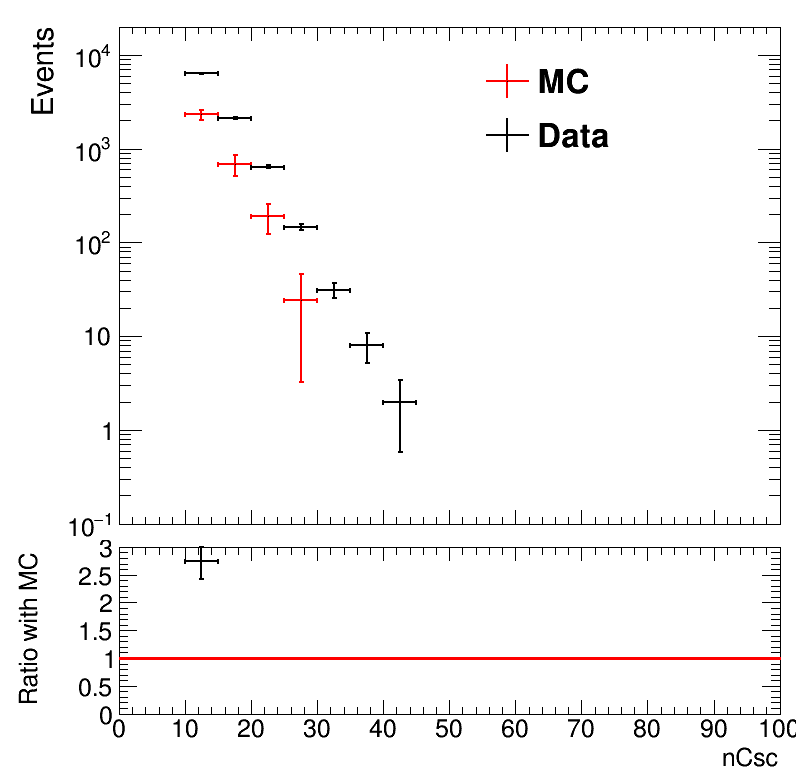

In [72]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

h = {}
rt.gStyle.SetOptFit(1011)
if pdgId == 13: data = 'SingleMuon'
else: data = 'SingleElectron'
mc = 'WJetsToLNu'
keys = [data,mc ]
for i,k in enumerate(keys):
#     w = cscClusterNLayer[k]*0.0 + weight[k]
#     print(len(w.flatten()))
#     print(len(cscClusterNLayer[k].flatten()))
#     h[k] = create_TH1D( cscClusterNLayer[k].flatten(), axis_title=['cluster station', 'Events'], name=k, binning=[10,0,10],weights = w.flatten())
#     h[k] = create_TH1D( nCscClusters[k], axis_title=['Number of Clusters', 'Events'], name=k, binning=[10,0,10],weights = weight[k])

#     h[k] = create_TH1D( cscClusterNLayer[k].sum(), axis_title=['Number of Stations per Event', 'Events'], name=k, binning=[10,0,10],weights = weight[k])
    print(np.sum(weight[k]))

#     print(len(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]))
    h[k] = create_TH1D( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], axis_title=['nCsc', 'Events'], name=k, binning=[20,0,100],weights = weight[k])
#     h[k] = create_TH1D( cscClusterTime[k][:,0], axis_title=['csc cluster time [ns]', 'Events'], name=k, binning=[30,-100,-12.5],weights = weight[k])

    h[k].SetLineColor(std_color_list[i])
#     leg.AddEntry(h[k], legend[k])
#     h[k].SetMinimum(1)

#     if k == data:
#         r = h[k].Fit('expo', 'LRSQ+', '', 20,120)
#         print(r.Get())
#         print(r.Prob())
#         h[k].GetFunction("expo").SetLineColor(std_color_list[2])
#         h[k].GetFunction("expo").SetLineWidth(2)


#     h[k].Draw('same')


c = make_ratio_plot([h[mc],h[data]], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])
# c.SetRightMargin(0)
# c.SetLogy()


c.Draw()

    
    


# c.Draw()
# print(time.time()-start_t)

# Data/MC veto efficiency plot

In [6]:
start_t = time.time()
pdgId = 13
JET_PT_CUT = 10
MUON_PT_CUT = 20

weight = {}
weight_event = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
rho = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
cscClusterMe11veto = {}
for k,T in tree_bkg.items():
    if pdgId == 13 and k == 'SingleElectron': continue
    if pdgId == 11 and k == 'SingleMuon': continue
    if k == 'WJetsToLNu': continue
    ###### OOT control region #####

    
#     sel_cluster = np.logical_and( sel_cluster, T.array('cscClusterMe1112Ratio') < 0.01)
    sel_cluster[k] = T.array('cscClusterMaxStationRatio')*T.array('cscClusterSize') > 5.01
#     sel_cluster[k] = np.logical_and( sel_cluster[k], T.array('cscClusterTime') > -12.5)
#     sel_cluster[k] = np.logical_and( sel_cluster[k], T.array('cscClusterTime') < 22) 
#     sel_cluster[k] = np.logical_and( sel_cluster[k],T.array('cscClusterJetVeto') < JET_PT_CUT)
#     sel_cluster[k] = np.logical_and( sel_cluster[k], T.array('cscClusterMuonVeto') < MUON_PT_CUT)
    sel_cluster[k] = np.logical_and(sel_cluster[k], T.array('cscClusterTime') < -12.5)
    sel_cluster[k] = np.logical_and(sel_cluster[k], T.array('cscClusterTime') > -62.5)
    cscClusterMe11veto[k] = T.array('cscClusterSize')*0.0
    print(k,"here")
#     for ev in range(len(cscClusterMe11veto[k])):
#         station = np.abs(T.array('cscStation')[ev]) == 11
#         cscLabels = T.array('cscLabels')[ev]
#         for cluster in range(len(cscClusterMe11veto[k][ev])):
#             # choose stations where the labels is this cluster
#             temp = np.logical_and(cscLabels == cluster, station)
#             if np.count_nonzero(temp) > 0:cscClusterMe11veto[k][ev][cluster] = 1
#         if ev%1000 == 0:
#             print(ev)
    print("here")
########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    # select only triggered events
    sel_ev= np.ones(hlt[:,0].shape, dtype=bool)
    sel_ev= np.zeros(hlt[:,0].shape)
    for tr in trigger_paths:            
        sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
    sel_muon = np.logical_and(T.array('lepPassId'), T.array('lepPt')>=25)
    sel_muon = np.logical_and(sel_muon, np.abs(T.array('lepEta'))<2.4)
    sel_muon = np.logical_and(sel_muon, np.abs(T.array('lepPdgId')) == 13)

    sel_ele = np.logical_and(T.array('lepPassId'), T.array('lepPt')>=35)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepEta'))<2.4)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepPdgId')) == 11)
    
    sel_lep = np.logical_or(sel_ele, sel_muon)
    sel_ev = np.logical_and(sel_ev, sel_lep.sum() == 1)
    sel_jetveto[k] = sel_ev

    ##### event variables #####
    weight[k] = sel_cluster[k]*0.0 + T.array('weight')*lumi
    runNum[k] = sel_cluster[k]*0.0 + T.array('runNum')
    npv[k] = sel_cluster[k]*0.0 + T.array('npv')
    npu[k] = sel_cluster[k]*0.0 + T.array('npu')
    rho[k] = sel_cluster[k]*0.0 + T.array('rho')

    print(k)

print(time.time()-start_t)

SingleMuon here
here
SingleMuon
103.89287447929382


284044.0 272775.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal


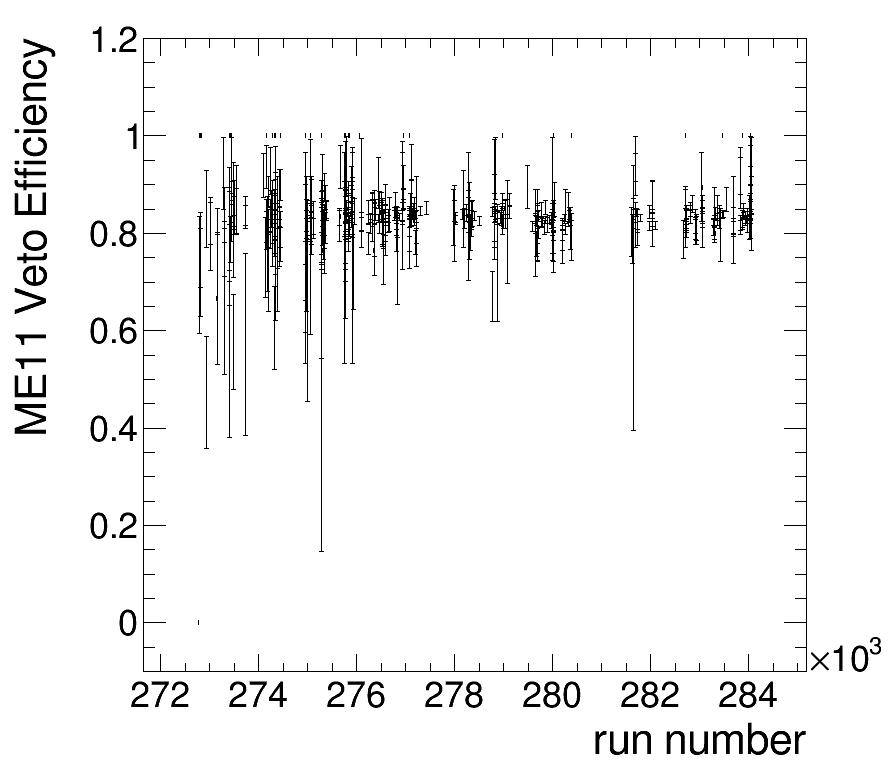

In [33]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

c = rt.TCanvas('c','c', 900, 800)
# Plotting ncsc
start_t = time.time()
leg = rt.TLegend(0.70,0.65,0.95,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}
rt.gStyle.SetOptFit(1011)
i = 0
rt.gStyle.SetOptFit(1011)
if pdgId == 13: data = 'SingleMuon'
else: data = 'SingleElectron'
mc = 'WJetsToLNu'
keys = [data,mc ]
for k,T in tree_bkg.items():
    if pdgId == 13 and k == 'SingleElectron': continue
    if pdgId == 11 and k == 'SingleMuon': continue
    if k == 'WJetsToLNu': continue
    bins = [20000,2.7E5,2.9E5]
#     bins = [2000,2.72E5,2.74E5]


    yaxis_title = 'ME11 Veto Efficiency'
#     hb = create_TH1D(npv[k][sel_cluster[k]][sel_jetveto[k]].flatten(), 'hb1', axis_title = ['npv',yaxis_title], binning=bins,weights = weight[k][sel_cluster[k]][sel_jetveto[k]].flatten())
    hb = create_TH1D(runNum[k][sel_cluster[k]][sel_jetveto[k]].flatten(), 'hb1', axis_title = ['run number',yaxis_title], binning=bins,weights = weight[k][sel_cluster[k]][sel_jetveto[k]].flatten())
    print(np.max(runNum[k][sel_cluster[k]][sel_jetveto[k]].flatten()),np.min(runNum[k][sel_cluster[k]][sel_jetveto[k]].flatten()))
    max_run = np.max(runNum[k][sel_cluster[k]][sel_jetveto[k]].flatten())
    min_run = np.min(runNum[k][sel_cluster[k]][sel_jetveto[k]].flatten())
    #     cond = np.logical_and(sel_cluster[k], T.array('cscClusterJetVeto') > 10)
#     cond = np.logical_and(sel_cluster[k], T.array('cscClusterMuonVeto') > 20)
    cond = np.logical_and(sel_cluster[k],  T.array('cscClusterMe11Ratio') > 0.0)



    
    hm = create_TH1D(runNum[k][cond][sel_jetveto[k]].flatten(), 'hm1', axis_title = ['run number', yaxis_title], binning=bins,weights = weight[k][cond][sel_jetveto[k]].flatten())


#     hm = create_TH1D(npv[k][cond][sel_jetveto[k]].flatten(), 'hm1', axis_title = ['npv', yaxis_title], binning=bins,weights = weight[k][cond][sel_jetveto[k]].flatten())
    h[k] = rt.TEfficiency(hm,hb)  
    h[k].SetLineColor(std_color_list[i])
    
    leg.AddEntry(h[k], legend[k])
#     h[k].SetMinimum(1)

    h[k].Draw('' if i==0 else 'same')
    for i in range(bins[0]):
        if h[k].GetEfficiency(i+1) < 0.01 and hb.GetBinContent(i+1) > 0:
            run = bins[1]+1.0*(bins[2]-bins[1])/bins[0]*i
            if run < max_run and run > min_run:
                print(bins[1]+1.0*(bins[2]-bins[1])/bins[0]*i)


#     h[k].Draw('same')
    i+=1
c.Draw()

# c = make_ratio_plot([h[mc].GetPaintedGraph(),h[data].GetPaintedGraph()], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])


# c = make_ratio_plot([h[mc],h[data]], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])
c.SetRightMargin(0.1)
# c.SetLogy()

# leg.Draw()


c.Draw()

h['SingleMuon'].GetPaintedGraph().GetYaxis().SetRangeUser(-0.1,1.2)


# c.Draw()
# print(time.time()-start_t)

# 2D plots

# ROC Curve

# ROC curve for different cluster moment hit

# nCsc histogram

In [ ]:
# output_root = rt.TFile("output.root","RECREATE")

start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.36,0.65,0.85,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}
# var = [nCsc,nCsc_recoJetVeto0p4,
#         nCsc_recoJetVeto0p4_Me1112Veto]
# name = ['nCsc','nCsc_recoJetVeto0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto']
# legend = ['','recoJetVeto #Delta R = 0.4',
#          'recoJetVeto #Delta R = 0.4, Me11 12Veto']


# var = [nCsc_recoJetVeto0p4,nCsc_JetVetoCluster0p4,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_JetVetoCluster0p4_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = ['nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']

# var = [nCsc_recoJetVeto0p4_Me1112Veto,nCsc_JetVetoCluster0p4_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4_Me1112Veto','nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = [ 'hit removal + ME11/12 veto','cluster removal + ME11/12 veto']

# var = [ nCsc_JetMuonVetoCluster0p4_Me1112Veto, 
#       nCsc_JetVetoCluster0p4_Me1112Veto,]
# name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto',
#         'nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = ['jet & muon veto + ME11/12 veto', 
#           'jet veto + ME11/12 veto']


#calojet vs pf
# var = [ nCsc_caloJetMuonVetoCluster0p4_Me1112Veto, 
#       nCsc_JetMuonVetoCluster0p4_Me1112Veto]
# name = ['nCsc_caloJetMuonVetoCluster0p4_Me1112Veto',
#         'nCsc_JetMuonVetoCluster0p4_Me1112Veto',]
# legend = ['calo jet & muon veto + ME11/12 veto', 
#           'pf jet & muon veto + ME11/12 veto',]

# pf vs. calo&pf
# var = [ nCsc_JetMuonVetoCluster0p4_Me1112Veto,nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto]
# name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto', 'nCsc_calopfJetMuonVetoCluster0p4_Me1112Veto']
# legend = ['pf jet & muon veto + ME11/12 veto','pf & calo jet & muon veto + ME11/12 veto']


# var = [ nCsc_caloJetMuonVetoCluster0p4_Me1112Veto, 
#       nCsc_JetVetoCluster0p4_Me1112Veto,]
# name = ['nCsc_caloJetMuonVetoCluster0p4_Me1112Veto',
#         'nCsc_JetVetoCluster0p4_Me1112Veto']
# legend = ['calo jet & muon veto + ME11/12 veto', 
#           'pf jet veto + ME11/12 veto']
# var = [nCsc_JetMuonVetoCluster0p4_Me1112Veto, nCsc_recoJetVeto0p4,nCsc_JetVetoCluster0p4]
# name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto','nCsc_recoJetVeto0p4','nCsc_JetVetoCluster0p4',]
# legend = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto','recoJetVeto #Delta R = 0.4','All clusters with JetVeto']





# var = [nCsc_recoJetVeto0p4,nCsc_recoJetVeto0p8,nCsc_recoJetVeto0p4_Me11Veto,nCsc_recoJetVeto0p8_Me11Veto,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_recoJetVeto0p8_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_recoJetVeto0p8','nCsc_recoJetVeto0p4_Me11Veto','nCsc_recoJetVeto0p8_Me11Veto',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_recoJetVeto0p8_Me1112Veto']
# legend = ['recoJetVeto #Delta R = 0.4','recoJetVeto #Delta R = 0.8','recoJetVeto #Delta R = 0.4, Me11Veto',
#           'recoJetVeto #Delta R = 0.8, Me11Veto','recoJetVeto #Delta R = 0.4, Me11 12Veto',
#           'recoJetVeto #Delta R = 0.8, Me11 12Veto']

#compare sum vs. most populated cluster
# var = [nCsc0_JetMuonVetoCluster0p4, nCsc0_JetMuonVetoCluster0p4_Me1112Veto, 
#        nCsc_JetMuonVetoCluster0p4,nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
# name = ['nCsc0_JetMuonVetoCluster0p4', 'nCsc0_JetMuonVetoCluster0p4_Me1112Veto', 
#        'nCsc_JetMuonVetoCluster0p4','nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
# legend = ['jet & muon veto, largest cluster', 'jet & muon veto + ME11/12 veto, largest cluster', 
# 'jet & muon veto, all clusters', 'jet & muon veto + ME11/12 veto, all clusters']

var = [nCsc_JetMuonEventVetoCluster0p4_Me1112Veto,nCsc_JetMuonVetoCluster0p4_Me1112Veto, ]
name =['nCsc_JetMuonEventVetoCluster0p4_Me1112Veto','nCsc_JetMuonVetoCluster0p4_Me1112Veto', ]
label = ['event veto','jet & muon veto + ME11/12 veto', ]




max_y = 0
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb10m'
bkg_nCsc = []
for i in range(len(var)):
    for k in tree_bkg.keys():
        if k == 'bbbb0.1m': continue
        if k == 'bbbb1m': continue
#         if k == 'bbbb10m': continue


#         cond = np.logical_and(event_Me1112Veto[k],event_recoJetVeto0p4[k])
        if i == 0:
            w = weight_event[k]
        else:
            w = weight[k]
        h[k+str(i)] = create_TH1D( var[i][k], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = w)
        if k[:4] == 'bbbb':
            h[k+str(i)].SetLineColor(std_color_list[0])
        else:
            h[k+str(i)].SetLineColor(std_color_list[1])
        h[k+str(i)].SetLineStyle(i+1)
        currentMax=h[k+str(i)].GetBinContent(h[k+str(i)].GetMaximumBin())
        if currentMax > max_y:
            max_y = currentMax
            h[k+str(i)].SetMaximum(5*currentMax)
            h[k+str(i)].SetMinimum(1)
        c.cd()
        
        if k == qcd_key and i == 0:
            r = h[k+str(i)].Fit('expo', 'LRSQ+', '', 10,100)
            print(r.Get())
            h[k+str(i)].GetFunction("expo").SetLineColor(std_color_list[2])
            h[k+str(i)].GetFunction("expo").SetLineWidth(2)
            for j in range(300):
                bkg_nCsc.append(h[k+str(i)].GetFunction("expo").Eval(j))
            bkg_nCsc = np.array(bkg_nCsc)

        h[k+str(i)].Draw("same hist")

        
#         output_root.cd()
#         h[k+str(i)].Write(k+"_"+name[i])
    #     gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])
#     gr[moment_xaxis[i]].SetMarkerStyle(std_color_list[i])


#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


        leg.AddEntry(h[k+str(i)],k+" "+label[i])

leg.Draw()
c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')
# output_root.Close()

print(time.time()-start_t)



In [ ]:
# output_root = rt.TFile("output.root","RECREATE")

start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.36,0.65,0.85,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}


cuts = [0]

max_y = 0
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb10m'
bkg_nCsc = []
for i,cut in enumerate(cuts):
    for k in tree_bkg.keys():
#         cond = np.logical_and(event_Me1112Veto[k],event_recoJetVeto0p4[k])
        cond = cscClusterXYSpread[k]>cut
        h[k+str(i)] = create_TH1D(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k][cond])
        if k[:4] == 'bbbb':
            h[k+str(i)].SetLineColor(std_color_list[0])
            if k=='bbbb10m':
                h[k+str(i)].SetLineStyle(2)
            if k=='bbbb1m':
                h[k+str(i)].SetLineStyle(3)
        else:
            h[k+str(i)].SetLineColor(std_color_list[1])
#         h[k+str(i)].SetLineStyle(i+1)
        currentMax=h[k+str(i)].GetBinContent(h[k+str(i)].GetMaximumBin())
        if currentMax > max_y:
            max_y = currentMax
            h[k+str(i)].SetMaximum(5*currentMax)
            h[k+str(i)].SetMinimum(1)
#         c.cd()
        
        h[k+str(i)].SetMaximum(10E4)

        if k == qcd_key and i == 0:
            r = h[k+str(i)].Fit('expo', 'LRSQ+', '', 20,100)
            print(r.Get())
            h[k+str(i)].GetFunction("expo").SetLineColor(std_color_list[2])
            h[k+str(i)].GetFunction("expo").SetLineWidth(2)
            for j in range(300):
                bkg_nCsc.append(h[k+str(i)].GetFunction("expo").Eval(j))
            bkg_nCsc = np.array(bkg_nCsc)
        h[k+str(i)].Draw("same hist")

        
#         output_root.cd()
#         h[k+str(i)].Write(k+"_"+name[i])
    #     gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])
#     gr[moment_xaxis[i]].SetMarkerStyle(std_color_list[i])


#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)

        leg.AddEntry(h[k+str(i)],legend[k]+" XY Moment cut = "+str(cuts[i])+" cm")

leg.Draw()
c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')
# output_root.Close()

print(time.time()-start_t)




In [ ]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.30,0.75,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
var = [nCsc,nCsc_recoJetVeto0p4,
        nCsc_recoJetVeto0p4_Me1112Veto]
name = ['nCsc','nCsc_recoJetVeto0p4',
        'nCsc_recoJetVeto0p4_Me1112Veto']
legend = ['','recoJetVeto #Delta R = 0.4',
         'recoJetVeto #Delta R = 0.4, Me11 12Veto']

# var = [nCsc_recoJetVeto0p4,nCsc_recoJetVeto0p8,nCsc_recoJetVeto0p4_Me11Veto,nCsc_recoJetVeto0p8_Me11Veto,
#         nCsc_recoJetVeto0p4_Me1112Veto,nCsc_recoJetVeto0p8_Me1112Veto]
# name = ['nCsc_recoJetVeto0p4','nCsc_recoJetVeto0p8','nCsc_recoJetVeto0p4_Me11Veto','nCsc_recoJetVeto0p8_Me11Veto',
#         'nCsc_recoJetVeto0p4_Me1112Veto','nCsc_recoJetVeto0p8_Me1112Veto']
# # moment_xaxis = ['sig_et1','sig_et2','sig_e1','sig_e2','sig_e','sig_et','etD','eD']
# legend = ['recoJetVeto #Delta R = 0.4','recoJetVeto #Delta R = 0.8','recoJetVeto #Delta R = 0.4, Me11Veto',
#           'recoJetVeto #Delta R = 0.8, Me11Veto','recoJetVeto #Delta R = 0.4, Me11 12Veto',
#           'recoJetVeto #Delta R = 0.8, Me11 12Veto']



max_y = 0
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
for k in tree_bkg.keys():
    cond = np.logical_and(event_recoJetVeto0p4[k], event_Me1112Veto[k])    
    h[k+'event'] = create_TH1D( nCsc[k][cond], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k][cond])
    h[k+'jetveto'] = create_TH1D( nCsc_recoJetVeto0p4_Me1112Veto[k], axis_title=['nCsc', 'Events'], name=k, binning=[30,0,300],weights = weight[k])

    if k == 'bbbb':
        h[k+'event'].SetLineColor(std_color_list[0])
        h[k+'jetveto'].SetLineColor(std_color_list[0])

    else:
        h[k+'event'].SetLineColor(std_color_list[1])
        h[k+'jetveto'].SetLineColor(std_color_list[1])

    h[k+'event'].SetLineStyle(0)
    h[k+'jetveto'].SetLineStyle(3)

#     currentMax=h[k+str(i)].GetBinContent(h[k+str(i)].GetMaximumBin())
#     if currentMax > max_y:
#         max_y = currentMax
    h[k+'event'].SetMaximum(5*10e6)
    h[k+'event'].SetMinimum(1)

#         h[k+str(i)].SetMinimum(1)
    h[k+'event'].Draw("same hist")
    h[k+'jetveto'].Draw("same hist")
#     gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])
#     gr[moment_xaxis[i]].SetMarkerStyle(std_color_list[i])


#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(h[k+'event'],k+" event veto #Delta R = 0.4, Me11 12Veto")
    leg.AddEntry(h[k+'jetveto'],k+" recoJetVeto #Delta R = 0.4, Me11 12Veto")

leg.Draw()
c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# event yield vs. ncsc

In [ ]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.45,0.80,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
h = {}
leg.SetEntrySeparation(0.01)
var = [nCsc,nCsc_recoJetVeto0p4,
        nCsc_recoJetVeto0p4_Me1112Veto]
name = ['nCsc','nCsc_recoJetVeto0p4',
        'nCsc_recoJetVeto0p4_Me1112Veto']
legend = ['','recoJetVeto #Delta R = 0.4',
         'recoJetVeto #Delta R = 0.4, Me11 12Veto']
var = [nCsc_JetMuonVetoCluster0p4, nCsc_JetMuonVetoCluster0p4_Me1112Veto, 
      nCsc_JetVetoCluster0p4_Me1112Veto,nCsc_JetVetoCluster0p4]
name = ['nCsc_JetMuonVetoCluster0p4','nCsc_JetMuonVetoCluster0p4_Me1112Veto',
        'nCsc_JetVetoCluster0p4_Me1112Veto','nCsc_JetVetoCluster0p4']
legend = ['jet & muon veto', 'jet & muon veto + ME11/12 veto', 
          'jet veto + ME11/12 veto','jet veto']
qcd_key = 'WJetsToLNu'
sig_k = 'bbbb'
threshold = np.array(list(range(300)))
for i in range(len(var)):
    event_count = {}
    for k in tree_bkg.keys():
        event_count[k] = []
        for th in threshold:
            event_count[k].append(np.sum(weight[k][var[i][k]>th]))
        event_count[k] = np.array(event_count[k])
    cond = np.logical_not(event_count[k] == 0)
#     gr['bbbb'] = create_TGraph(eff_bkg,eff_sig,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    h[sig_k+str(i)] = create_TGraph(threshold[cond], event_count[sig_k][cond],  axis_title=['nCsc', 'Signal Yield'])
    h[sig_k+str(i)].SetLineColor(std_color_list[i])
    h[sig_k+str(i)].SetLineWidth(2)
    h[sig_k+str(i)].SetMarkerColor(std_color_list[i])
    h[sig_k+str(i)].GetXaxis().SetRangeUser(0, 300)
    h[sig_k+str(i)].SetMaximum(10000)

#     h[sig_k+str(i)].GetYaxis().SetRangeUser(0, 50000)
    leg.AddEntry(h[sig_k+str(i)],sig_k+" "+legend[i])
    h[sig_k+str(i)].Draw('ac' if i == 0 else 'c')
leg.Draw()

c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# significance

In [ ]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.65,0.70,0.85,0.80)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)


bkg_k = 'WJetsToLNu'
keys = ['bbbb1m', 'bbbb10m']
br = 0.1

threshold = list(range(300))
threshold = np.array(list(range(300)))
# print(threshold)
for i, sig_k in enumerate(keys):
    event_count = {}

    for k in tree_bkg.keys():
        event_count[k] = []
        for th in threshold:
            if k == qcd_key:
                event_count[k].append(np.sum(bkg_nCsc[th:]))
#                 print(th,np.sum(bkg_nCsc[th:]))
            else:
                event_count[k].append(np.sum(weight[k][nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>th]))
        event_count[k] = np.array(event_count[k])
        if k == sig_k:
            event_count[k] = event_count[k]*br
    sig = event_count[sig_k]/np.sqrt(event_count[sig_k]+event_count[bkg_k])
    cond = event_count[sig_k]>0
    sig = sig[cond]
    ncsc = threshold[cond]
    print(event_count[sig_k][cond][ncsc==100], event_count[bkg_k][cond][ncsc==100], sig[ncsc==100])
#     gr['bbbb'] = create_TGraph(eff_bkg,eff_sig,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    h[sig_k] = create_TGraph(ncsc, sig,  axis_title=['nCsc', 'Significnace'])
    h[sig_k].SetLineWidth(2)
    h[sig_k].SetMarkerColor(std_color_list[i])
    h[sig_k].SetLineColor(std_color_list[i])
    h[sig_k].GetXaxis().SetRangeUser(0, 500)
    h[sig_k].GetYaxis().SetRangeUser(0, 5)
    h[sig_k].GetXaxis().SetLabelSize(0.046)

    leg.AddEntry(h[sig_k],legend[sig_k])
    h[sig_k].Draw('ac' if i == 0 else 'c')

#     h[sig_k+str(i)].Draw('ac' if i==0 else 'c')
#     gr['bbbb'].Draw('')




leg.Draw()
# c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)
